In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, torch
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../../")))
from libs import data, hdc, helper, nn, sim
from cfgs.fedargs import *

In [3]:
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [4]:
train_data, test_data = data.load_dataset(fedargs.dataset, only_to_tensor = True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True, **kwargs)

In [5]:
fedargs.model = hdc.HDC(fedargs.one_d_len, fedargs.hdc_proj_len, len(fedargs.labels), device)

In [6]:
# Train    
train_acc = fedargs.model.train(train_loader, device)
#fedargs.model.load_state_dict(torch.load('hdc.pth'))

In [7]:
# Test, Plot and Log
test_acc = fedargs.model.test(test_loader, device)

In [8]:
hdc_train_vectors = fedargs.model.train_vectors

In [9]:
#print(train_acc, test_acc)
print(test_acc)

82.2300033569336


In [10]:
hdc_train_vectors

tensor([[413594.1562, 390797.1562, 409961.3750,  ..., 410616.0625,
         398484.3125, 400035.5938],
        [208951.5781, 212726.1250, 185367.2812,  ..., 195493.6719,
         198841.2188, 190918.4062],
        [353545.4375, 347936.0312, 339464.1250,  ..., 347765.1250,
         338524.1562, 342029.1875],
        ...,
        [298596.1562, 282200.2188, 282753.6250,  ..., 279368.7812,
         270344.1562, 271063.1562],
        [357189.7812, 349922.8125, 332973.8438,  ..., 349237.8438,
         333702.3438, 332882.6562],
        [298082.3438, 286517.2812, 282852.2500,  ..., 284992.3125,
         267025.3438, 279061.9062]])

In [11]:
model = nn.ModelMNIST()

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024, shuffle=True, **kwargs)

In [13]:
'''
# Train
from tqdm import tqdm

fedargs.epochs = 5
fedargs.local_rounds = 1
for epoch in tqdm(range(fedargs.epochs)):
    _, model, loss = fedargs.train_func(model, train_loader, 
                                        fedargs.learning_rate,
                                        fedargs.weight_decay,
                                        fedargs.local_rounds, device)
torch.save(model.state_dict(), 'nn.pth')                                        
'''
model.load_state_dict(torch.load('nn.pth'))
model.eval()

ModelMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [14]:
test_output = fedargs.eval_func(model, test_loader, device)
print(test_output)

{'test_loss': 0.07843767547607422, 'correct': 9745, 'accuracy': 97.45}


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f

def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze() 
    print('Predict class confidence:',ps)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
def predict(model, img, view = False):
    with torch.no_grad():
        logits = model.forward(img)

    ps = f.softmax(logits, dim=1)
    if view:
        view_classify(img.view(1, 28, 28), ps)
    
    _, label = torch.max(ps, 1)
    return label 

tensor([5])

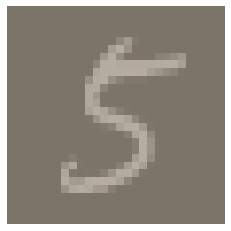

In [92]:
image, label = next(iter(test_loader))
lbl = label[0]
helper.imshow(image[0])
img5 = image[0].unsqueeze(0)
predict(model, img5)

tensor([8])

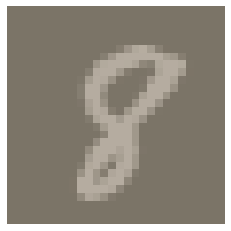

In [74]:
image, label = next(iter(test_loader))
lbl = label[0]
helper.imshow(image[0])
img8 = image[0].unsqueeze(0)
predict(model, img8)

In [75]:
print(img5.shape, img8.shape)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


tensor([9])


<AxesSubplot:>

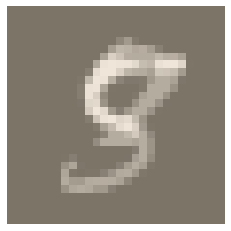

In [111]:
_img5 = copy.deepcopy(img5)
_img8 = copy.deepcopy(img8)

for d in range(500):
    _img5 = _img5.reshape(1, 784)
    _img8 = _img8.reshape(1, 784)
    _img5[0][d] = _img8[0][d] +  _img5[0][d]
    _img5 = _img5.reshape(1, 1, 28, 28)

print(predict(model, _img5))
helper.imshow(_img5.squeeze(0))